In [34]:
import pandas as pd 
import numpy as np
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import tensorflow as tf

csvfile = "Data_testing.csv"  #file name 
#csvfile = "Data_actor2000.pt.csv"  #file name 

In [35]:
data_test= pd.read_csv(csvfile)
data_test.head()

,Episode,Kick_Speed,friction,variance_friction,Rewards,Stop_Distance
0,0,53.50,0.7,0.3,-151.74,60.15
1,1,25.93,0.7,0.3,0.00,6.80
2,2,7.22,0.7,0.3,0.00,6.78
3,3,29.28,0.7,0.3,0.00,6.65
4,4,50.76,0.7,0.3,-206.31,64.62


In [18]:
profile = ProfileReport(data_test, minimal=True)
profile.to_file(output_file="output.html")

In [36]:
failed = data_test[data_test['Stop_Distance'] <= 5]
passed = data_test[data_test['Stop_Distance'] > 5]

print('Size of crashes :',failed.shape[0])  
print('Size of success :',passed.shape[0]) 
print("Percentage of crash cases:{:.2f}".format(failed.shape[0]*100/(failed.shape[0]+passed.shape[0])),"%")
print("Percentage of not crashed cases:{:.2f}".format(passed.shape[0]*100/(failed.shape[0]+passed.shape[0])),"%")

#failed.to_csv("crashed.csv",index=False)
#failed.head()

Size of crashes : 0
Size of success : 3000
Percentage of crash cases:0.00 %
Percentage of not crashed cases:100.00 %


In [37]:
#passed.to_csv("not_crashed.csv",index=False  )
#passed.head()

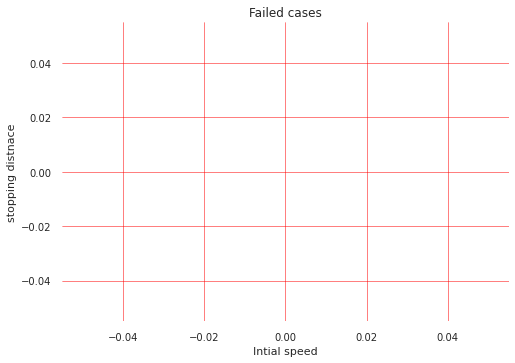

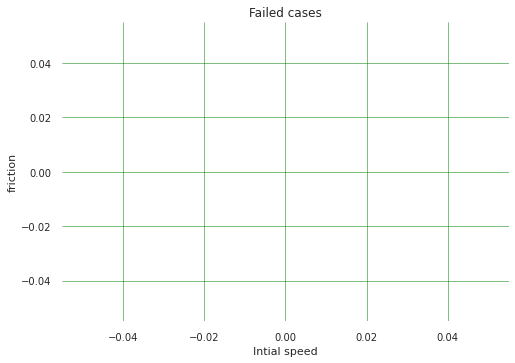

In [38]:
fig=plt.figure
plt.scatter(failed["Kick_Speed"],failed["Stop_Distance"],label='Line 2')
plt.grid(color='r', linestyle='-', linewidth=0.5)
plt.title("Failed cases")
plt.xlabel("Intial speed")
plt.ylabel("stopping distnace")
plt.show()

fig=plt.figure
plt.scatter(failed["friction"],failed["Stop_Distance"],label='Line 2')
plt.grid(color='g', linestyle='-', linewidth=0.5)
plt.title("Failed cases")
plt.xlabel("Intial speed")
plt.ylabel("friction")
plt.show()


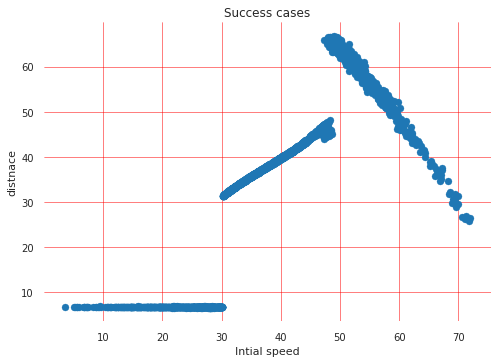

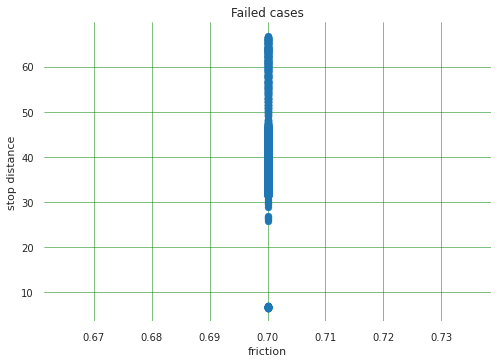

In [39]:
fig=plt.figure
plt.scatter(passed["Kick_Speed"],passed["Stop_Distance"])
plt.grid(color='r', linestyle='-', linewidth=0.5)
plt.title("Success cases")
plt.xlabel("Intial speed")
plt.ylabel("distnace")
plt.show()

fig=plt.figure
plt.scatter(passed["friction"],passed["Stop_Distance"],label='Line 2')
plt.grid(color='g', linestyle='-', linewidth=0.5)
plt.title("Failed cases")
plt.xlabel("friction")
plt.ylabel("stop distance")
plt.show()

In [40]:
data_test.loc[data_test['Stop_Distance'] <= 5, 'test'] = int(1)
data_test.loc[data_test['Stop_Distance'] > 5, 'test'] = int(0)
data_test.head()

,Episode,Kick_Speed,friction,variance_friction,Rewards,Stop_Distance,test
0,0,53.50,0.7,0.3,-151.74,60.15,0.0
1,1,25.93,0.7,0.3,0.00,6.80,0.0
2,2,7.22,0.7,0.3,0.00,6.78,0.0
3,3,29.28,0.7,0.3,0.00,6.65,0.0
4,4,50.76,0.7,0.3,-206.31,64.62,0.0


Total number of episodes: 3000
Number of Pass: 2999
Number of fail: 0


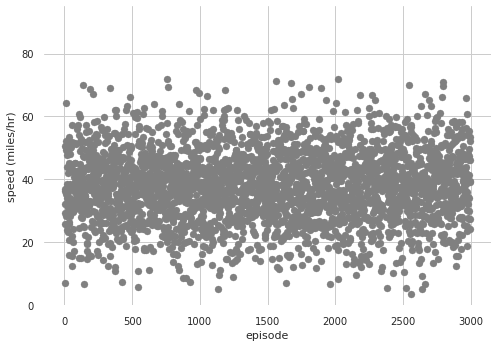

In [41]:
print('Total number of episodes:',data_test['Episode'].shape[0])
start=1
end=9642

fig, ax = plt.subplots()
episode=np.array(data_test['Episode'].values.tolist()[start:end])
test=np.array(data_test['test'].values.tolist()[start:end])
speed=np.array(data_test['Kick_Speed'].values.tolist()[start:end])

indices = test == 0
print('Number of Pass:',indices.sum())
print('Number of fail:',indices.shape[0]-indices.sum())

# normal values
ax.scatter(episode[~indices], speed[~indices], c = 'red',label='fail')
# bad values
ax.scatter(episode[indices], speed[indices], c = 'grey',label='Pass')
#ax.legend()
ax.set_ylim([0,95])
plt.xlabel('episode')
plt.ylabel('speed (miles/hr)')
ax.grid(True) 
plt.show()
figname=csvfile+'.png'
fig.savefig(figname)

Failures:  [0, 0, 0, 0, 0, 0, 0, 0]


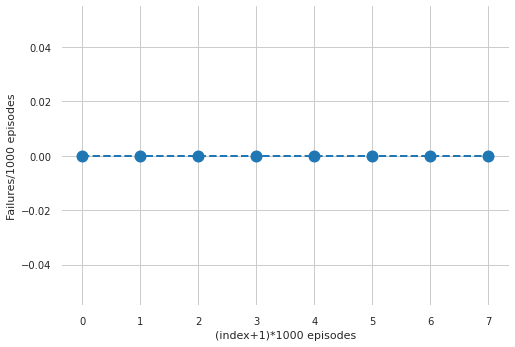

In [32]:
step=500
failure=[]
fig, ax = plt.subplots()
for i in range(int(data_test['Episode'].shape[0]/step)):
    start=step*i
    episode=np.array(data_test['Episode'].values.tolist()[start:start+step])
    test=np.array(data_test['test'].values.tolist()[start:start+step])
    indices = test == 1
    failure.append(indices.sum())
print('Failures: ',failure)
ax.plot(failure,marker='o', linestyle='dashed',linewidth=2, markersize=12)
plt.xlabel('(index+1)*1000 episodes')
plt.ylabel('Failures/1000 episodes')
ax.grid(True) 
plt.show()   

In [33]:
#data for AVF training:
iteration_start=1000
iteration_end=4000
data=data_test[["Episode", "Kick_Speed","test"]][iteration_start:iteration_end]
std=np.std(data[["Episode", "Kick_Speed"]].values,axis=0)
mean=np.mean(data[["Episode", "Kick_Speed"]].values,axis=0)
np.savez('stdmean.npz',std=std, mean=mean)
data[["Episode", "Kick_Speed"]]=np.divide(np.subtract(data[["Episode", "Kick_Speed"]],mean),std)
print('std is:',std)
print('Mean is:',mean)
data.head()

std is: [866.02535567  11.02501264]
Mean is: [2499.5          38.33647333]


,Episode,Kick_Speed,test
1000,-1.731474,0.347712,0.0
1001,-1.730319,0.822995,0.0
1002,-1.729164,1.048845,0.0
1003,-1.728009,1.304627,0.0
1004,-1.726855,0.683312,0.0


In [34]:
#AVF Training 


X=data[["Episode","Kick_Speed"]].values
print(X.shape)
Y=data["test"]
print(Y.shape)
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

#test train split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
print(X[1,:].shape)

#callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.999):
      print("\nReached 99% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

# Model

model = tf.keras.models.Sequential([tf.keras.layers.InputLayer(input_shape=(2,)), 
                                    tf.keras.layers.Dense(64, activation=tf.nn.relu),
                                    tf.keras.layers.Dense(32, activation=tf.nn.relu),
                                    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid )
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=500, batch_size=8, callbacks=[callbacks]) ;


(3000, 2)
(3000,)
(2,)
Epoch 1/500
252/252 [==============================] - 0s 2ms/step - loss: 0.1110 - accuracy: 0.9950
Epoch 2/500
245/252 [============================>.] - ETA: 0s - loss: 0.0020 - accuracy: 1.0000
Reached 99% accuracy so cancelling training!
252/252 [==============================] - 0s 2ms/step - loss: 0.0019 - accuracy: 1.0000


In [13]:
results = model.evaluate(x_test, y_test, batch_size=16)
print('test loss, test acc:', results)

62/62 [==============================] - 0s 1ms/step - loss: 0.0073 - accuracy: 0.9970
test loss, test acc: [0.00732088927179575, 0.9969696998596191]


In [14]:
!mkdir -p saved_model
model.save('saved_model/my_model') 

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [15]:
# my_model directory
!ls saved_model

# Contains an assets folder, saved_model.pb, and variables folder.
!ls saved_model/my_model

my_model
assets	saved_model.pb	variables


In [16]:
new_model = tf.keras.models.load_model('saved_model/my_model')